## Final Assignment 

#### Taim Hassouni - s205040
#### Mostafa Al-Gharifi - s205425

Our project combines datasets on box office earnings, Rotten Tomatoes metadata and reviews, user ratings, and movie details into a unified resource to explore potential relationships between sentiment scores from text reviews, box office performance, and movie ratings. 

After loading the datasets, we normalized the movie titles to enable matching across sources, linking Rotten Tomatoes data with box office and movie metadata. We then saved the cleaned dataset as a CSV file, making it ready for analysis

In [ ]:
import pandas as pd
from fuzzywuzzy import fuzz, process

#---------------------------
# Load your datasets (example paths, adjust as needed)
#---------------------------
movies_df = pd.read_csv('movies.csv')  # columns: ['movieId', 'title', 'genres']
ratings_df = pd.read_csv('ratings.csv') # columns: ['userId', 'movieId', 'rating', 'timestamp']
box_office_df = pd.read_csv('All Time Worldwide Box Office.csv')
rotten_tomatoes_movies_df = pd.read_csv('rotten_tomatoes_movies.csv')
critic_reviews_df = pd.read_csv('rotten_tomatoes_critic_reviews.csv')

# Keep only essential columns for merging
movies_df = movies_df[['movieId', 'title']] 
ratings_df = ratings_df[['movieId', 'rating']]
box_office_df = box_office_df[['Movie', 'WorldwideBox Office', 'DomesticBox Office', 'InternationalBox Office']]
rotten_tomatoes_movies_df = rotten_tomatoes_movies_df[['rotten_tomatoes_link', 'movie_title']]
critic_reviews_df = critic_reviews_df[['rotten_tomatoes_link', 'review_content']]

# Rename Box Office columns for easier referencing
box_office_df = box_office_df.rename(columns={
    "WorldwideBox Office": "WorldwideBoxOffice",
    "DomesticBox Office": "DomesticBoxOffice",
    "InternationalBox Office": "InternationalBoxOffice"
})

def normalize_title(title):
    return ''.join(e for e in title.lower() if e.isalnum() or e.isspace()).strip()

# Normalize titles
box_office_df['bo_title_normalized'] = box_office_df['Movie'].apply(normalize_title)
rotten_tomatoes_movies_df['rt_title_normalized'] = rotten_tomatoes_movies_df['movie_title'].apply(normalize_title)
movies_df['movie_title_normalized'] = movies_df['title'].apply(normalize_title)

#---------------------------
# 1. Fuzzy match Rotten Tomatoes titles to Box Office titles
#---------------------------
box_office_titles = box_office_df['bo_title_normalized'].tolist()
rt_to_bo_matches = [
    (
        rt_title, 
        process.extractOne(rt_title, box_office_titles, scorer=fuzz.token_sort_ratio)
    )
    for rt_title in rotten_tomatoes_movies_df['rt_title_normalized']
]

# Filter matches above threshold (e.g., 80)
rt_to_bo_filtered = [
    (rt, bo[0], bo[1]) for rt, bo in rt_to_bo_matches if bo is not None and bo[1] >= 80
]

rt_bo_df = pd.DataFrame(rt_to_bo_filtered, columns=['rt_title_normalized', 'bo_title_normalized', 'match_score_bo'])

#---------------------------
# 2. Fuzzy match Rotten Tomatoes titles to movies.csv titles
#---------------------------
movie_titles = movies_df['movie_title_normalized'].tolist()
rt_to_movies_matches = [
    (
        rt_title, 
        process.extractOne(rt_title, movie_titles, scorer=fuzz.token_sort_ratio)
    )
    for rt_title in rotten_tomatoes_movies_df['rt_title_normalized']
]

# Filter matches above threshold (e.g., 80)
rt_to_movies_filtered = [
    (rt, mv[0], mv[1]) for rt, mv in rt_to_movies_matches if mv is not None and mv[1] >= 80
]

rt_movies_df = pd.DataFrame(rt_to_movies_filtered, columns=['rt_title_normalized', 'movie_title_normalized', 'match_score_mv'])

#---------------------------
# 3. Merge the fuzzy match results with the original datasets
#---------------------------
# Merge Rotten Tomatoes <-> Box Office
rt_bo_merged = pd.merge(rt_bo_df, box_office_df[['bo_title_normalized','Movie','WorldwideBoxOffice']],
                        on='bo_title_normalized', how='inner')

# Merge Rotten Tomatoes <-> Movies
rt_mv_merged = pd.merge(rt_movies_df, movies_df[['movieId','title','movie_title_normalized']],
                        on='movie_title_normalized', how='inner')

# Merge both to get the triple link (RT <-> Box Office <-> Movies)
triple_merged = pd.merge(rt_bo_merged, rt_mv_merged, on='rt_title_normalized', how='inner')

# Merge with rotten_tomatoes_movies_df to get rotten_tomatoes_link
final_merge = pd.merge(triple_merged, 
                       rotten_tomatoes_movies_df[['rotten_tomatoes_link','rt_title_normalized','movie_title']],
                       on='rt_title_normalized', how='inner')

# Merge with ratings to get avg_rating
avg_ratings = ratings_df.groupby('movieId')['rating'].mean().reset_index()
avg_ratings = avg_ratings.rename(columns={'rating':'avg_rating'})
final_merge = pd.merge(final_merge, avg_ratings, on='movieId', how='inner')

# Merge with critic_reviews_df on rotten_tomatoes_link
final_df = pd.merge(final_merge, critic_reviews_df, on='rotten_tomatoes_link', how='inner')

# Select columns of interest
final_df = final_df[['title', 'rotten_tomatoes_link', 'avg_rating', 'WorldwideBoxOffice', 'review_content']]

#---------------------------
# Convert review_content to string to avoid TypeError during aggregation
#---------------------------
final_df['review_content'] = final_df['review_content'].astype(str)

#---------------------------
# Optional: If you want one row per movie, aggregate all reviews
#---------------------------
final_aggregated_df = final_df.groupby(['title','rotten_tomatoes_link','avg_rating','WorldwideBoxOffice'], as_index=False).agg({
    'review_content': lambda x: ' '.join(x)
})

print(final_aggregated_df.head())

# Save the final aggregated dataset
final_aggregated_df.to_csv('final_merged_dataset_cleaned.csv', index=False)


We begin by importing the necessary libraries for data analysis, text processing, and machine learning, including pandas for handling data, TextBlob for sentiment analysis, and sklearn for feature extraction and regression modeling. 

We then load the cleaned dataset:

In [48]:
import pandas as pd
import re
from textblob import TextBlob
from sklearn.feature_extraction.text import TfidfVectorizer
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
import string

# Load the final aggregated DataFrame
final_aggregated_df = pd.read_csv('final_merged_dataset_cleaned.csv')



We clean the data to prepare it for analysis. The WorldwideBoxOffice column is converted to numeric format by removing symbols like $ and ,. The review_content column is cleaned by converting it to strings, removing any 'nan' tokens, making all text lowercase, removing punctuation, and trimming extra spaces.

In [49]:
def parse_box_office(value):
    # Remove $, commas and convert to float
    return float(re.sub(r'[\$,]', '', value))

final_aggregated_df['WorldwideBoxOffice'] = final_aggregated_df['WorldwideBoxOffice'].apply(parse_box_office)

# Convert review_content to string and handle potential 'nan' tokens
final_aggregated_df['review_content'] = final_aggregated_df['review_content'].astype(str)

# Remove explicit 'nan' tokens if they appear in the text
final_aggregated_df['review_content'] = final_aggregated_df['review_content'].str.replace(r'\bnan\b', '', regex=True)

# Additional cleaning: remove punctuation, convert to lowercase
def clean_text(text):
    # Lowercase
    text = text.lower()
    # Remove punctuation
    text = text.translate(str.maketrans('', '', string.punctuation))
    # Remove extra whitespace
    text = ' '.join(text.split())
    return text

final_aggregated_df['review_content'] = final_aggregated_df['review_content'].apply(clean_text)


After cleaning the Data we use TF-IDF (Term Frequency-Inverse Document Frequency) to extract important features from the cleaned review content. The TfidfVectorizer is set up to remove common English stopwords, limit the features to unigrams and bigrams, and extract the top 1000 terms based on importance. After fitting the vectorizer to the review text, we generate a matrix of TF-IDF scores. For example, we extract and display the top 10 most relevant terms for the first movie in the dataset, ranked by their TF-IDF scores

In [50]:
tfidf_vectorizer = TfidfVectorizer(
    max_features=1000,     # Adjust if needed
    stop_words='english',  # Remove English stopwords
    ngram_range=(1,2)      # Unigrams and bigrams
)

tfidf_matrix = tfidf_vectorizer.fit_transform(final_aggregated_df['review_content'])
feature_names = tfidf_vectorizer.get_feature_names_out()

# Example: Print top TF-IDF features for the first movie after cleaning
first_movie_vector = tfidf_matrix[0]
sorted_indices = first_movie_vector.toarray()[0].argsort()[::-1]
top_10_features = [(feature_names[i], first_movie_vector.toarray()[0][i]) for i in sorted_indices[:10]]

print("Top 10 TF-IDF features for the first movie (after cleaning):")
for feature, score in top_10_features:
    print(feature, ":", score)
 

Top 10 TF-IDF features for the first movie (after cleaning):
disney : 0.6451517025083389
disneys : 0.41614957485531223
animated : 0.2697373185889736
feature : 0.17277314384251788
animation : 0.14120530243824136
features : 0.10491604807944645
studios : 0.10432572538244618
years : 0.09869233920858214
film : 0.09828376207730029
cute : 0.09445738252788764


We calculate the sentiment score for each movie review using TextBlob, which assigns a polarity score to the text based on its sentiment. This score ranges from -1 (strongly negative) to 1 (strongly positive). The polarity is determined using a lexicon-based approach: each word in the text is assigned a predefined sentiment value from a dictionary, with positive words like "excellent" scoring close to +1, negative words like "terrible" scoring close to -1, and neutral words scoring 0. 

Modifiers like "not" or "very" are accounted for to adjust the impact of words. The overall score is computed as the weighted average of the word scores in the text. We store these polarity values in a new column, sentiment_score, and display the first few titles along with their calculated scores to get an overview of the sentiment in the reviews.

In [51]:
def get_sentiment_score(text):
    analysis = TextBlob(text)
    return analysis.sentiment.polarity

final_aggregated_df['sentiment_score'] = final_aggregated_df['review_content'].apply(get_sentiment_score)
print(final_aggregated_df[['title', 'sentiment_score']].head())


                   title  sentiment_score
0  101 Dalmatians (1996)         0.285267
1  101 Dalmatians (1996)         0.309903
2  102 Dalmatians (2000)         0.092606
3  21 Jump Street (2012)         0.131549
4  21 Jump Street (2012)         0.152992


Above are some examples of sentiment scores for reviews for a couple of movies

In [52]:
import pandas as pd
import plotly.express as px

# If you haven't already:
# final_aggregated_df = pd.read_csv('final_merged_dataset_cleaned.csv')

# Ensure the DataFrame has 'sentiment_score', 'avg_rating', and 'WorldwideBoxOffice'
print(final_aggregated_df.columns)


Index(['title', 'rotten_tomatoes_link', 'avg_rating', 'WorldwideBoxOffice',
       'review_content', 'sentiment_score'],
      dtype='object')


---------------------------------------------------------------------------------------------------------------------------------------------------------

Above we double check that all the required coloumns are presents before proceeding

Now we can make scatter plots showcasing the relationships between sentiment scores, average ratings, and worldwide box office earnings. The first plot explores how sentiment scores correlate with box office performance, with hover details revealing movie titles and average ratings.

The second plot examines the connection between average ratings and box office revenue, helping identify whether higher-rated movies perform better financially.

Finally, the third plot combines these insights, using bubble size and color to represent average ratings while plotting sentiment scores against box office earnings. 

In [53]:
fig_sentiment_boxoffice = px.scatter(
    final_aggregated_df,
    x='sentiment_score',
    y='WorldwideBoxOffice',
    title='Sentiment Score vs. Worldwide Box Office',
    labels={'sentiment_score': 'Sentiment Score', 'WorldwideBoxOffice': 'Worldwide Box Office'},
    hover_data=['title', 'avg_rating']  # Optional: display title and avg_rating on hover
)

fig_sentiment_boxoffice.show()


In [54]:
fig_rating_boxoffice = px.scatter(
    final_aggregated_df,
    x='avg_rating',
    y='WorldwideBoxOffice',
    title='Average Rating vs. Worldwide Box Office',
    labels={'avg_rating': 'Average Rating', 'WorldwideBoxOffice': 'Worldwide Box Office'},
    hover_data=['title', 'sentiment_score']  # Optional: show sentiment on hover
)

fig_rating_boxoffice.show()


In [55]:
import plotly.express as px

fig = px.scatter(
    final_aggregated_df,
    x='sentiment_score',
    y='WorldwideBoxOffice',
    size='avg_rating',
    color='avg_rating',  # Coloring points by rating for a nice gradient
    title='Sentiment vs. Box Office with Ratings as Bubble Size',
    labels={'sentiment_score': 'Sentiment Score', 'WorldwideBoxOffice': 'Worldwide Box Office'},
    hover_data=['title']
)
fig.show()


## ***Scatter plots reflection:***

##### *Sentiment Score vs. Worldwide Box Office:*

This plot shows how sentiment scores relate to box office performance. While most movies cluster around lower sentiment scores, there doesn’t appear to be a strong correlation between sentiment and worldwide box office. Some movies with low sentiment still perform well financially, indicating that sentiment alone may not be a reliable predictor of box office success.

##### *Average Rating vs. Worldwide Box Office:*

The second plot explores how average audience ratings relate to box office revenue. Compared to sentiment scores, this plot reveals a slightly more structured trend, where movies with higher average ratings tend to perform better at the box office. However, this relationship is not uniform, as there are movies with both high and low box office performance across the rating spectrum.

##### *Sentiment, Ratings, and Box Office (Bubble Plot):*

The third plot combines sentiment scores, box office revenue, and average ratings into a single visualization. Here, bubble size and color reflect average ratings, creating a more nuanced view. It becomes evident that while sentiment scores and ratings provide some context, box office performance is not consistently tied to either metric. However, movies with larger bubble sizes (higher ratings) tend to cluster at higher box office earnings, suggesting that ratings might have a stronger influence than sentiment scores.

## **Key Differences:**
The first plot focuses purely on sentiment scores, showing a loose and scattered distribution with no strong patterns.
The second plot introduces average ratings, which demonstrate a more apparent relationship with box office success.
The third plot integrates both variables, emphasizing how ratings (size and color of bubbles) interact with box office revenue, revealing a clearer influence compared to sentiment scores.

These plots suggest that while sentiment and ratings provide valuable insights, neither is a definitive predictor of box office performance. Ratings seem to have a slightly stronger impact on earnings than sentiment scores, but other factors (e.g., marketing, genre, or audience reach) likely play a significant role. Combining multiple variables in the third plot offers a more holistic view and highlights the complex nature of what drives box office success.

In [56]:
import plotly.express as px
fig = px.histogram(
    final_aggregated_df,
    x='sentiment_score',
    nbins=50,
    title='Distribution of Sentiment Scores',
    labels={'sentiment_score': 'Sentiment Score'}
)
fig.show()


This histogram visualizes the distribution of sentiment scores across all movie reviews, highlighting the frequency of different sentiment levels. It provides insight into whether reviews are generally positive, negative, or neutral.

 It provides additional context for the scatter plots by showing the overall sentiment range and clustering, helping to better understand how sentiment scores relate to box office performance and ratings.

In [58]:
import pandas as pd
import re
import string
import matplotlib.pyplot as plt
from wordcloud import WordCloud, STOPWORDS
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

# Download NLTK data files (only need to run once)
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')




[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\mustafa\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\mustafa\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\mustafa\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


True

---------------------------------------------------------------------------------------------------------------------------------------------------------

Now that we have our scatter plots and histogram to understand the quantitative relationships between sentiment, ratings, and box office performance, we want to dive deeper into the qualitative aspects of the reviews. By generating word clouds, we can uncover the recurring themes and language used in different subsets of movies, providing additional context to complement our numerical analysis.

Above we install nltk. The Natural Language Toolkit (nltk) is used for advanced text processing, such as removing stopwords and lemmatization.

To enable nltk's features, the script downloads essential language resources

This section below defines tools for text cleaning:

Stopwords: Combines standard NLTK stopwords, WordCloud stopwords, and dataset-specific terms (e.g., "movie," "film") to remove uninformative words.
Lemmatizer: Initializes the WordNet lemmatizer to reduce words to their base forms, improving text consistency for analysis.

In [59]:
# Define NLTK stopwords
nltk_stopwords = set(stopwords.words('english'))

# Define additional stopwords specific to your dataset
additional_stopwords = {'nan', 'movie', 'movies', 'film', 'films', 'story', 'game', 'games', 'Make', 'Character', 'Much', 'One'}

# Combine all stopwords
all_stopwords = nltk_stopwords.union(additional_stopwords).union(STOPWORDS)

# Initialize the WordNet lemmatizer
lemmatizer = WordNetLemmatizer()


In [60]:
def clean_text(text):
    # Convert to lowercase
    text = text.lower()
    
    # Remove punctuation
    text = text.translate(str.maketrans('', '', string.punctuation))
    
    # Remove numbers
    text = re.sub(r'\d+', '', text)
    
    # Tokenize the text
    tokens = text.split()
    
    # Remove stopwords and lemmatize
    cleaned_tokens = [lemmatizer.lemmatize(word) for word in tokens if word not in all_stopwords]
    
    # Join back into a single string
    cleaned_text = ' '.join(cleaned_tokens)
    
    return cleaned_text

# Apply the cleaning function to the review_content column
final_aggregated_df['cleaned_review_content'] = final_aggregated_df['review_content'].apply(clean_text)

# Optionally, inspect the cleaned reviews
print(final_aggregated_df[['title', 'cleaned_review_content']].head())


                   title                             cleaned_review_content
0  101 Dalmatians (1996)  doglovers particular go gaga remarkably fresh ...
1  101 Dalmatians (1996)  one great disney classic league snow white pin...
2  102 Dalmatians (2000)  given level violence cartoonish id question wi...
3  21 Jump Street (2012)  vibrant fresh due brilliant pairing hill tatum...
4  21 Jump Street (2012)  jump street becomes little selfaware good tatu...


------------------------------------------------------------------------------------------------------------------------------------------------------

The cleaned text is saved in a new column, cleaned_review_content, for further analysis. For example, the reviews are now free of irrelevant words and noise, making them suitable for sentiment and keyword analysis. The first few cleaned reviews are displayed to inspect the results. Now we are ready to generate our wordclouds:

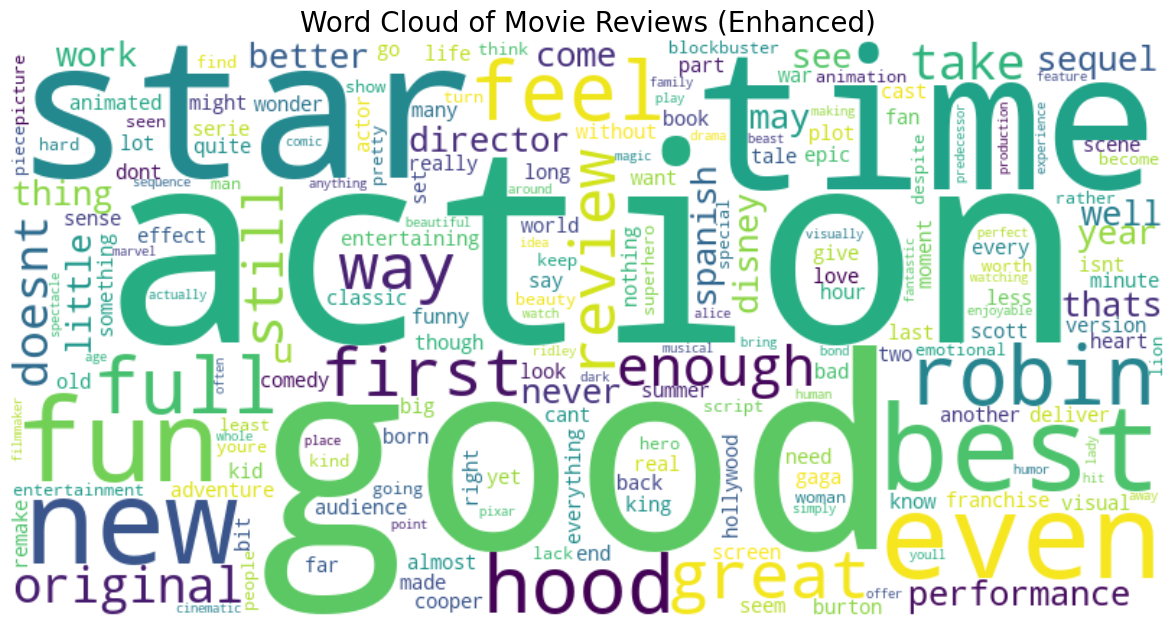

In [61]:
from wordcloud import WordCloud, STOPWORDS

# Combine all cleaned review text into a single string
all_cleaned_text = ' '.join(final_aggregated_df['cleaned_review_content'].tolist())

# Create and generate a word cloud image
wordcloud = WordCloud(
    width=800,
    height=400,
    background_color='white',
    max_words=200,            # Adjust as needed
    stopwords=all_stopwords,  # Use the enhanced stopwords
    colormap='viridis',       # Choose a color map
    collocations=False        # Avoid duplicate bigrams
).generate(all_cleaned_text)

# Display the generated image
plt.figure(figsize=(15, 7.5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud of Movie Reviews (Enhanced)', fontsize=20)
plt.show()


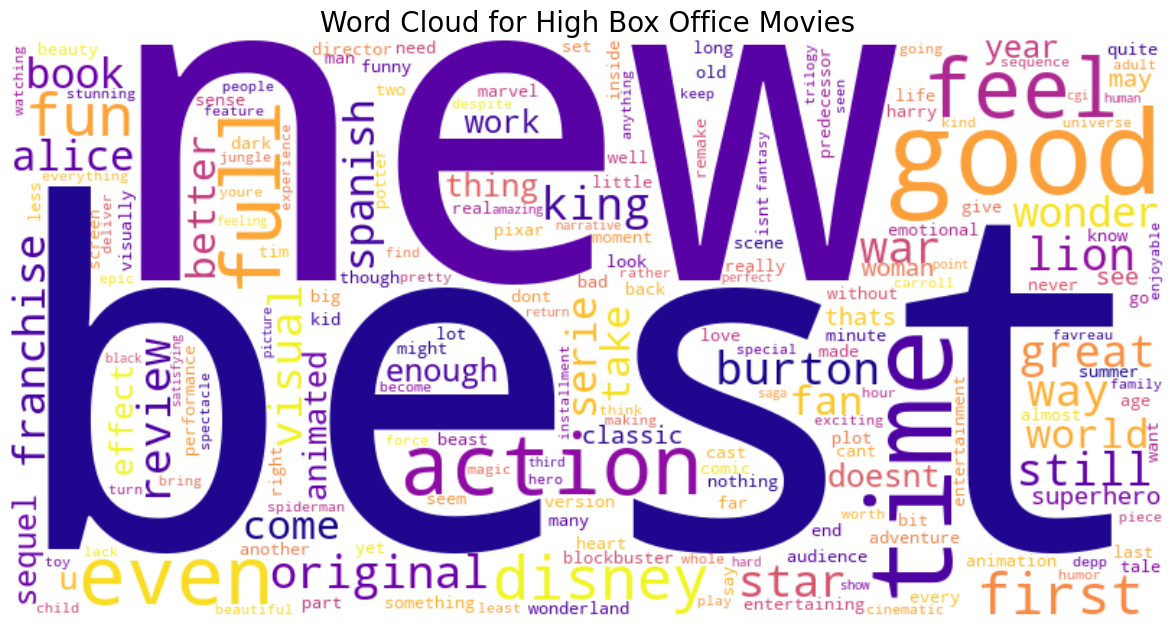

In [62]:
# Define a threshold for high box office (e.g., top 25%)
threshold = final_aggregated_df['WorldwideBoxOffice'].quantile(0.75)
high_box_office_df = final_aggregated_df[final_aggregated_df['WorldwideBoxOffice'] >= threshold]

# Combine cleaned review text for high box office movies
high_box_office_text = ' '.join(high_box_office_df['cleaned_review_content'].tolist())

# Generate word cloud
wordcloud_high = WordCloud(
    width=800,
    height=400,
    background_color='white',
    max_words=200,
    stopwords=all_stopwords,
    colormap='plasma',
    collocations=False
).generate(high_box_office_text)

# Display
plt.figure(figsize=(15, 7.5))
plt.imshow(wordcloud_high, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud for High Box Office Movies', fontsize=20)
plt.show()


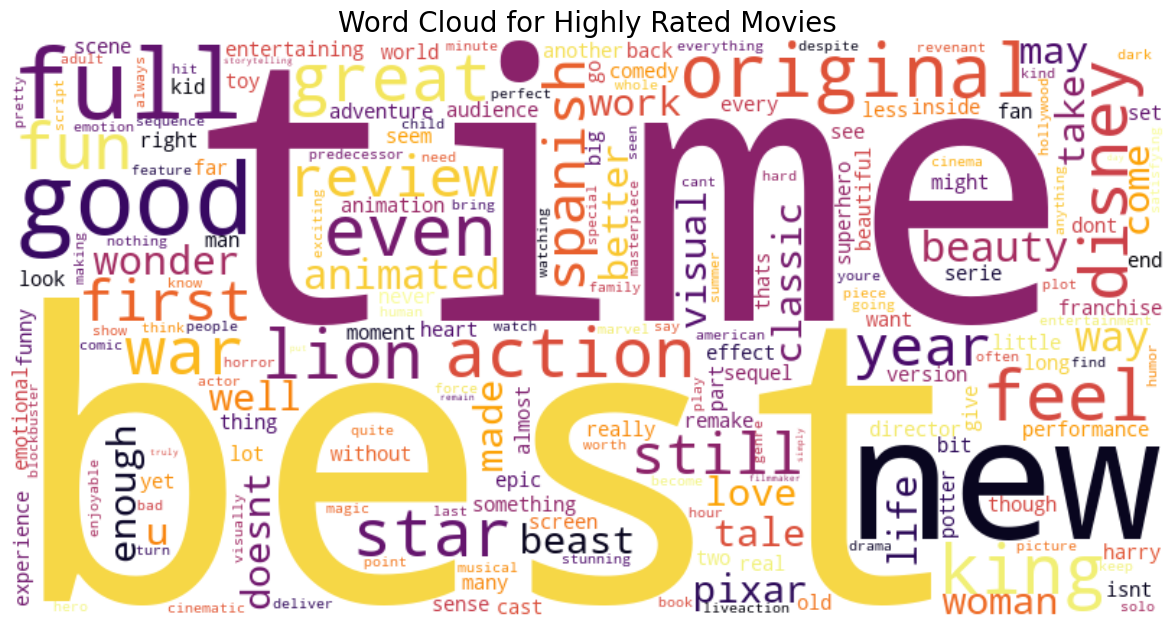

In [63]:
# Define a threshold for high ratings (e.g., top 25%)
rating_threshold = final_aggregated_df['avg_rating'].quantile(0.75)
high_rated_df = final_aggregated_df[final_aggregated_df['avg_rating'] >= rating_threshold]

# Combine cleaned review text for highly rated movies
high_rated_text = ' '.join(high_rated_df['cleaned_review_content'].tolist())

# Generate word cloud
wordcloud_high_rated = WordCloud(
    width=800,
    height=400,
    background_color='white',
    max_words=200,
    stopwords=all_stopwords,
    colormap='inferno',
    collocations=False
).generate(high_rated_text)

# Display
plt.figure(figsize=(15, 7.5))
plt.imshow(wordcloud_high_rated, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud for Highly Rated Movies', fontsize=20)
plt.show()


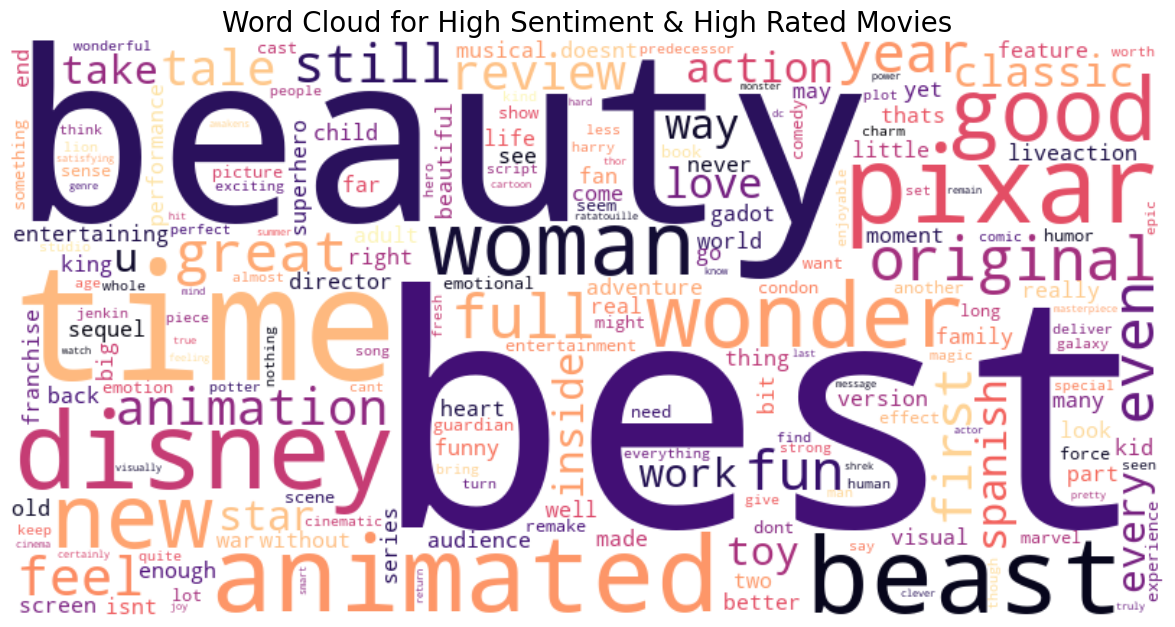

In [64]:
# Define thresholds for high sentiment and high ratings (e.g., top 25% each)
sentiment_threshold = final_aggregated_df['sentiment_score'].quantile(0.75)
combined_high_df = final_aggregated_df[
    (final_aggregated_df['sentiment_score'] >= sentiment_threshold) & 
    (final_aggregated_df['avg_rating'] >= rating_threshold)
]

# Combine cleaned review text for combined high sentiment and high ratings
combined_high_text = ' '.join(combined_high_df['cleaned_review_content'].tolist())

# Generate word cloud
wordcloud_combined_high = WordCloud(
    width=800,
    height=400,
    background_color='white',
    max_words=200,
    stopwords=all_stopwords,
    colormap='magma',
    collocations=False
).generate(combined_high_text)

# Display
plt.figure(figsize=(15, 7.5))
plt.imshow(wordcloud_combined_high, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud for High Sentiment & High Rated Movies', fontsize=20)
plt.show()


## ***Word Clouds Reflection:***

##### *Overall Word Cloud:*

The first word cloud represents all movie reviews, highlighting the most common terms across the dataset. Words like "good," "action," "time," and "even" dominate, reflecting general sentiments and themes associated with movies. This word cloud provides a baseline for comparison with specific subsets, showing a broad focus on positivity and descriptive language.

##### *High Box Office Word Cloud:*

The word cloud for movies with the highest box office earnings emphasizes terms like "action," "new," "best," and "original." These words suggest that commercially successful movies often feature engaging action, originality, and appeal to broad audiences. Mentions of franchises like "Disney" and "Pixar" underline the impact of family-friendly and blockbuster productions on box office success.

##### *Highly Rated Movies Word Cloud:*

For highly rated movies, terms such as "best," "original," "king," and "classic" stand out. These words indicate that critically acclaimed films often highlight creativity, strong narratives, and emotional resonance. Words like "feel" and "full" emphasize the completeness and emotional depth that resonate with audiences and critics alike.

##### *High Sentiment & High Rated Movies Word Cloud:*
The word cloud for movies with both high sentiment and high ratings highlights terms like "beauty," "best," "animated," and "time." These terms reflect a focus on visual and emotional excellence, which aligns with both audience positivity and critical acclaim. Mentions of "woman" and "wonder" suggest that representation and empowerment may play a role in the success of these movies.

## **Key Takeaways:**
The overall word cloud provides a general view of the themes and language used in reviews, while the subset-specific word clouds uncover unique characteristics of different groups:

**High box office movies emphasize broad appeal, action, and franchise power.**

**Highly rated movies focus more on originality, emotional depth, and storytelling.**

**Movies with high sentiment and high ratings balance visual excellence, representation, and critical and audience praise.**

In [65]:
import pandas as pd
import networkx as nx
from textblob import TextBlob
import itertools

# Assume you have final_aggregated_df from the previous code
final_aggregated_df = pd.read_csv('final_merged_dataset_cleaned.csv')

#---------------------------
# Compute sentiment scores for each movie
#---------------------------
def get_sentiment_score(text):
    return TextBlob(text).sentiment.polarity

# We'll group by 'title' in case there are duplicates, though final_aggregated_df should already be aggregated
movie_sentiment = final_aggregated_df.groupby('title', as_index=False).agg({'review_content':'first'})
movie_sentiment['sentiment_score'] = movie_sentiment['review_content'].apply(get_sentiment_score)

# Create a Graph
G = nx.Graph()

# Add nodes for each movie with sentiment_score as an attribute
for _, row in movie_sentiment.iterrows():
    G.add_node(row['title'], sentiment_score=row['sentiment_score'])

# Define a similarity threshold for edges
threshold = 0.05

# Create edges between movies that have similar sentiment scores
movies_list = movie_sentiment['title'].tolist()
sentiment_dict = dict(zip(movie_sentiment['title'], movie_sentiment['sentiment_score']))

for m1, m2 in itertools.combinations(movies_list, 2):
    diff = abs(sentiment_dict[m1] - sentiment_dict[m2])
    if diff <= threshold:
        G.add_edge(m1, m2)

# Print the number of nodes and edges
print("Number of nodes:", G.number_of_nodes())
print("Number of edges:", G.number_of_edges())


Number of nodes: 443
Number of edges: 34775


In the above code we use a network graph to explore relationships between movies based on sentiment scores. Each movie is represented as a node, with edges connecting movies that have similar sentiment scores (within a threshold, e.g., 0.05). This approach helps identify clusters of movies with comparable emotional responses, offering insights into broader patterns in audience reception.

In [66]:
import plotly.graph_objects as go

# Compute positions using spring layout
pos = nx.spring_layout(G, k=0.1, iterations=50)

# Extract edge positions
edge_x = []
edge_y = []
for u, v in G.edges():
    x0, y0 = pos[u]
    x1, y1 = pos[v]
    edge_x.append(x0)
    edge_x.append(x1)
    edge_x.append(None)  # Separate edges
    edge_y.append(y0)
    edge_y.append(y1)
    edge_y.append(None)

# Extract node positions and attributes
node_x = []
node_y = []
node_text = []  # For hover information
for node in G.nodes():
    x, y = pos[node]
    node_x.append(x)
    node_y.append(y)
    # You can show sentiment_score or other attributes on hover
    sentiment = nx.get_node_attributes(G, 'sentiment_score').get(node, 'N/A')
    node_text.append(f"{node}<br>Sentiment Score: {sentiment:.2f}")

# Create Plotly traces
edge_trace = go.Scatter(
    x=edge_x, y=edge_y,
    line=dict(width=0.5, color='lightgray'),
    hoverinfo='none',
    mode='lines')

node_trace = go.Scatter(
    x=node_x, y=node_y,
    mode='markers',
    hoverinfo='text',
    text=node_text,
    marker=dict(
        showscale=True,
        # Color nodes by sentiment
        colorscale='Blues',
        color=[nx.get_node_attributes(G, 'sentiment_score')[n] for n in G.nodes()],
        size=5,
        colorbar=dict(
            title="Sentiment Score"
        ),
        line_width=1))

fig = go.Figure(data=[edge_trace, node_trace],
                layout=go.Layout(
                    title='Interactive Graph of Movies (Sentiment-Based Similarity)',
                    title_x=0.5,
                    showlegend=False,
                    hovermode='closest',
                    margin=dict(b=20,l=5,r=5,t=40)
                ))

fig.update_layout(template="plotly_white")

fig.show()


Each node represents a movie, colored by its sentiment score (darker blue indicates higher sentiment). Edges connect movies with similar sentiment scores, as determined by a small threshold (e.g., 0.05). The layout uses a spring algorithm, clustering closely related movies together while spacing apart those with distinct sentiment profiles.

Hovering over a node reveals the movie title and its sentiment score, providing detailed insights. This graph highlights patterns in audience sentiment, with clusters representing groups of movies with similar emotional tones, and isolated nodes indicating unique sentiment profiles. 

## ***Sentiment Analysis Observations***

The sentiment analysis provides a fascinating lens through which to explore the relationships between movie reviews, themes, and audience perception. By calculating sentiment scores for movie reviews and visualizing these scores in various contexts, we can identify several key observations:

##### *Sentiment Graph Observations:*

The sentiment-based similarity graph highlights a linear clustering of movies based on sentiment polarity. Movies with similar sentiment scores are closely connected, forming a chain-like structure. This visualization suggests that sentiment is a consistent and measurable attribute across diverse movies, reinforcing its reliability for comparing audience perceptions.

##### *Impact of Sentiment on Other Metrics:*

Scatter plots showed limited correlation between sentiment and box office performance, emphasizing that sentiment alone does not determine financial success. Similarly, when paired with ratings, sentiment offered a more nuanced view, indicating that while sentiment contributes to audience perception, it may not directly translate into tangible success indicators like revenue.

In networks like the similarity graph, sentiment clustering revealed thematic or stylistic groupings of movies. These communities help capture how sentiment reflects shared elements across films, such as tone, narrative style, or genre.

**Key findings** so far suggest that while review scores (e.g., average ratings) show a slight positive correlation with box office performance, sentiment scores do not exhibit a strong or consistent relationship with financial success. This indicates that while audience sentiment reflects perceptions and emotions tied to a movie, external factors such as marketing, distribution, or franchise appeal may play a more significant role in determining box office outcomes

Now that we've made our interactive sentiment graph, we proceed with analyzing the movie reviews using TF-IDF vectorization and clustering. This allows us to group movies based on the themes in their reviews, uncovering patterns and similarities:

In [67]:
import pandas as pd
import re
import string
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans

#---------------------------
# 1. Load Data
#---------------------------
# Assuming you have the final_aggregated_df.csv
final_aggregated_df = pd.read_csv('final_merged_dataset_cleaned.csv')

# Ensure 'review_content' column exists
if 'review_content' not in final_aggregated_df.columns:
    raise ValueError("DataFrame does not have 'review_content' column.")

#---------------------------
# 2. Preprocessing Function
#---------------------------
def clean_text(text):
    # Convert to lowercase
    text = text.lower()
    # Remove punctuation
    text = text.translate(str.maketrans('', '', string.punctuation))
    # Remove digits
    text = re.sub(r'\d+', '', text)
    # Strip extra whitespace
    text = ' '.join(text.split())
    return text

final_aggregated_df['cleaned_review'] = final_aggregated_df['review_content'].apply(clean_text)

#---------------------------
# 3. TF-IDF Vectorization
#---------------------------
# Adjust parameters as needed:
# - stop_words='english': remove English stopwords
# - max_features=1000: limit to 1000 most important terms (optional)
# - ngram_range=(1,1): unigrams only; you can try (1,2) for bigrams
tfidf_vectorizer = TfidfVectorizer(
    stop_words='english',
    max_features=1000,
    ngram_range=(1,1)
)

tfidf_matrix = tfidf_vectorizer.fit_transform(final_aggregated_df['cleaned_review'])
feature_names = tfidf_vectorizer.get_feature_names_out()

print("TF-IDF matrix shape:", tfidf_matrix.shape)
# This will print something like (num_movies, 1000) if max_features=1000

#---------------------------
# 4. Inspecting TF-IDF Results
#---------------------------
# Let's pick the first document/movie to see its top terms.
doc_index = 0
doc_vector = tfidf_matrix[doc_index].toarray().flatten()
# Get indices sorted by TF-IDF score in descending order
sorted_indices = doc_vector.argsort()[::-1]

print("\nTop 10 TF-IDF features for the first document:")
for i in sorted_indices[:10]:
    print(f"{feature_names[i]}: {doc_vector[i]:.4f}")

#---------------------------
# 5. Optional: Clustering Documents
#---------------------------
# For example, cluster the movies into 5 groups
num_clusters = 5
kmeans = KMeans(n_clusters=num_clusters, random_state=42)
kmeans.fit(tfidf_matrix)
cluster_labels = kmeans.labels_

# Attach cluster labels back to the DataFrame
final_aggregated_df['cluster'] = cluster_labels

print("\nNumber of documents in each cluster:")
print(final_aggregated_df['cluster'].value_counts())

# Print top terms per cluster
print("\nTop terms per cluster:")
order_centroids = kmeans.cluster_centers_.argsort()[:, ::-1]
for cluster_id in range(num_clusters):
    top_terms = [feature_names[ind] for ind in order_centroids[cluster_id, :10]]
    print(f"Cluster {cluster_id}: {', '.join(top_terms)}")

#---------------------------
# 6. Further Analysis
#---------------------------
# You can now:
# - Inspect specific clusters to see which movies fall into them.
# - Correlate cluster membership with avg_rating or WorldwideBoxOffice.
# - Use dimensionality reduction (PCA, t-SNE) for visualization.

# Example: Print a few movie titles from each cluster
for c in range(num_clusters):
    cluster_samples = final_aggregated_df[final_aggregated_df['cluster'] == c].head(5)
    print(f"\nSample movies from cluster {c}:")
    print(cluster_samples['title'].values)


TF-IDF matrix shape: (521, 1000)

Top 10 TF-IDF features for the first document:
disney: 0.6207
disneys: 0.4004
nan: 0.2756
animated: 0.2595
feature: 0.1662
animation: 0.1359
features: 0.1009
studios: 0.1004
years: 0.0950
film: 0.0946

Number of documents in each cluster:
cluster
3    219
1    134
2     74
0     67
4     27
Name: count, dtype: int64

Top terms per cluster:
Cluster 0: nan, film, movie, comedy, sequel, story, good, original, fun, like
Cluster 1: movie, film, like, just, action, fun, sequel, good, time, horror
Cluster 2: animated, animation, disney, film, pixar, movie, kids, story, lion, like
Cluster 3: film, movie, action, like, story, good, just, best, spielberg, nan
Cluster 4: comedy, funny, movie, romantic, film, laughs, like, good, just, jokes

Sample movies from cluster 0:
['101 Dalmatians (1996)' '102 Dalmatians (2000)'
 'Alice in Wonderland (1951)' 'American Me (1992)' 'Animatrix, The (2003)']

Sample movies from cluster 1:
['300: Rise of an Empire (2014)' 'A Quie

The output reveals thematic clusters of movies based on their review content. The TF-IDF matrix, with 521 movies and 1000 key terms, highlights the most important words for each review, such as "disney" and "animated" for the first document, reflecting a Disney-related theme. Using KMeans, the movies are grouped into five clusters with distinct focuses: comedy and sequels (Cluster 0), action and horror (Cluster 1), animated and Disney movies (Cluster 2), story-driven and Spielberg-like movies (Cluster 3), and comedic-romantic films (Cluster 4). Cluster sizes range from 27 to 219 movies, with representative examples like "101 Dalmatians" in Cluster 2 and "21 Jump Street" in Cluster 4. These clusters provide insight into the dominant themes in movie reviews.

In [70]:
import re

# Extract the year from the title using a regex pattern to match (dddd)
final_aggregated_df['year'] = final_aggregated_df['title'].str.extract(r'\((\d{4})\)')

# Check if there are any rows that didn't match and resulted in NaN
missing_year_rows = final_aggregated_df[final_aggregated_df['year'].isna()]

if not missing_year_rows.empty:
    print("Rows missing year information:")
    print(missing_year_rows[['title']])
    # Decide what to do with these rows:
    # Option 1: Drop rows without a year
    final_aggregated_df = final_aggregated_df.dropna(subset=['year'])
    # Option 2: If you prefer a default year (not recommended unless you have a good reason):
    # final_aggregated_df['year'] = final_aggregated_df['year'].fillna(0)

# Convert year to integer
final_aggregated_df['year'] = final_aggregated_df['year'].astype(int)

# Verify
print(final_aggregated_df[['title', 'year']].head())


Rows missing year information:
                title
367  Ready Player One
                   title  year
0  101 Dalmatians (1996)  1996
1  101 Dalmatians (1996)  1996
2  102 Dalmatians (2000)  2000
3  21 Jump Street (2012)  2012
4  21 Jump Street (2012)  2012


C:\Users\mustafa\AppData\Local\Temp\ipykernel_26644\3414122498.py:19: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



We then extract the release year from movie titles using a regex pattern that identifies four-digit numbers in parentheses (e.g., (1996)). Movies without a valid year, such as "Ready Player One," are identified, and rows with missing year information are dropped from the dataset. The extracted year values are converted to integers for consistency. The output confirms successful extraction, with the first few rows showing correctly assigned years like "1996" for "101 Dalmatians" and "2000" for "102 Dalmatians." Additionally, a warning about modifying a slice of the DataFrame is displayed but does not impact the process. This step ensures that each movie has a reliable year value for further analysis.

In [71]:
import pandas as pd
import numpy as np
import re
import string
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
import networkx as nx
import matplotlib.pyplot as plt

#-------------------------------------------------------
# 1. Ensure we have year and cleaned_review columns
#    Assuming final_aggregated_df is already loaded and has them:
#    final_aggregated_df['year'] must exist
#    final_aggregated_df['cleaned_review'] must exist (as in your working code)
#-------------------------------------------------------

# Split dataset into older (year < 2000) and newer (year >= 2000)
older_df = final_aggregated_df[final_aggregated_df['year'] < 2000].copy()
newer_df = final_aggregated_df[final_aggregated_df['year'] >= 2000].copy()

print("Older movies (<2000):", older_df.shape)
print("Newer movies (>=2000):", newer_df.shape)

#-------------------------------------------------------
# 2. TF-IDF Vectorization
#    Use the 'cleaned_review' column since it already works.
#-------------------------------------------------------
def build_tfidf_matrix(reviews):
    tfidf = TfidfVectorizer(
        max_features=1000,      # Adjust as needed
        stop_words='english',   # Removes English stopwords
        ngram_range=(1,2)       # Use unigrams and bigrams
    )
    return tfidf.fit_transform(reviews), tfidf

older_tfidf_matrix, older_tfidf_vec = build_tfidf_matrix(older_df['cleaned_review'])
newer_tfidf_matrix, newer_tfidf_vec = build_tfidf_matrix(newer_df['cleaned_review'])

#-------------------------------------------------------
# 3. Build Similarity Networks
#-------------------------------------------------------
def build_similarity_network(titles, tfidf_matrix, threshold=0.3):
    sim_matrix = cosine_similarity(tfidf_matrix)
    G = nx.Graph()
    # Add nodes
    for t in titles:
        G.add_node(t)
    # Add edges
    num_movies = len(titles)
    for i in range(num_movies):
        for j in range(i+1, num_movies):
            if sim_matrix[i, j] >= threshold:
                G.add_edge(titles[i], titles[j], weight=sim_matrix[i, j])
    return G

older_titles = older_df['title'].tolist()
newer_titles = newer_df['title'].tolist()

G_older = build_similarity_network(older_titles, older_tfidf_matrix, threshold=0.3)
G_newer = build_similarity_network(newer_titles, newer_tfidf_matrix, threshold=0.3)

#-------------------------------------------------------
# 4. Analyze Each Network
#-------------------------------------------------------
def analyze_network(G, era_name):
    print(f"\n*** {era_name} Network Analysis *")
    print("Number of nodes:", G.number_of_nodes())
    print("Number of edges:", G.number_of_edges())
    
    if nx.is_empty(G):
        print("The graph is empty!")
        return
    
    largest_cc = max(nx.connected_components(G), key=len)
    print("Size of largest connected component:", len(largest_cc))
    
    communities = nx.algorithms.community.greedy_modularity_communities(G)
    print("Number of communities found:", len(communities))

analyze_network(G_older, "Older (<2000)")
analyze_network(G_newer, "Newer (>=2000)")

#-------------------------------------------------------
# 5. (Optional) Visualize Each Network
#   You can color nodes by year or cluster, but since you only have two subsets,
#   the year variation might be smaller in the 'older' subset. Here we just show how:
#-------------------------------------------------------
def visualize_network(G, era_name):
    plt.figure(figsize=(12,12))
    pos = nx.spring_layout(G, k=0.15, iterations=50)
    nx.draw_networkx_nodes(G, pos, node_size=50, node_color='blue', alpha=0.7)
    nx.draw_networkx_edges(G, pos, width=0.2, alpha=0.5, edge_color='gray')
    plt.title(f"{era_name} Movie Similarity Network", fontsize=16)
    plt.axis('off')
    plt.show()

# Visualize if desired:
# visualize_network(G_older, "Older (<2000)")
# visualize_network(G_newer, "Newer (>=2000)")

Older movies (<2000): (170, 8)
Newer movies (>=2000): (350, 8)

*** Older (<2000) Network Analysis *
Number of nodes: 130
Number of edges: 1497
Size of largest connected component: 127
Number of communities found: 11

*** Newer (>=2000) Network Analysis *
Number of nodes: 312
Number of edges: 5517
Size of largest connected component: 298
Number of communities found: 28


We explore thematic connections between movies by splitting the dataset into two subsets: older movies (pre-2000) and newer movies (2000 and later). TF-IDF vectorization captures the key terms in reviews, and cosine similarity is used to build networks where nodes represent movies and edges indicate thematic similarity (above a threshold of 0.3).

Older Movies (<2000): 130 nodes, 1497 edges, 11 communities.

Largest connected component: 127 movies.

Newer Movies (>=2000): 312 nodes, 5517 edges, 28 communities.

Largest connected component: 298 movies.

In [72]:
import pandas as pd
import re
import string
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx

# ---------------------------
# 1. Load Data
# ---------------------------
final_aggregated_df = pd.read_csv('final_merged_dataset_cleaned.csv')

# Clean the reviews
final_aggregated_df['cleaned_review'] = final_aggregated_df['review_content'].fillna('').replace('nan', '')
final_aggregated_df['year'] = final_aggregated_df['title'].str.extract(r'\((\d{4})\)').astype(float)

# Split older and newer movies
older_df = final_aggregated_df[final_aggregated_df['year'] < 2000].copy()
newer_df = final_aggregated_df[final_aggregated_df['year'] >= 2000].copy()

# ---------------------------
# 2. TF-IDF Vectorization and Clustering
# ---------------------------
def build_clusters(df, num_clusters=5):
    tfidf_vectorizer = TfidfVectorizer(
        stop_words='english',
        max_features=1000,
        ngram_range=(1, 2)
    )
    tfidf_matrix = tfidf_vectorizer.fit_transform(df['cleaned_review'])
    feature_names = tfidf_vectorizer.get_feature_names_out()

    kmeans = KMeans(n_clusters=num_clusters, random_state=42)
    kmeans.fit(tfidf_matrix)

    df['cluster'] = kmeans.labels_
    return df, tfidf_matrix, tfidf_vectorizer, kmeans

# Build clusters for older and newer movies
older_df, older_tfidf_matrix, older_vec, older_kmeans = build_clusters(older_df, num_clusters=5)
newer_df, newer_tfidf_matrix, newer_vec, newer_kmeans = build_clusters(newer_df, num_clusters=10)

# ---------------------------
# 3. Print Top Terms for Each Cluster
# ---------------------------
def print_top_terms_per_cluster(tfidf_matrix, feature_names, kmeans, num_terms=10):
    order_centroids = kmeans.cluster_centers_.argsort()[:, ::-1]
    for cluster_id in range(kmeans.n_clusters):
        top_terms = [feature_names[ind] for ind in order_centroids[cluster_id, :num_terms]]
        print(f"Cluster {cluster_id}: {', '.join(top_terms)}")

print("\nTop Terms for Older Movie Communities:")
print_top_terms_per_cluster(older_tfidf_matrix, older_vec.get_feature_names_out(), older_kmeans)

print("\nTop Terms for Newer Movie Communities:")
print_top_terms_per_cluster(newer_tfidf_matrix, newer_vec.get_feature_names_out(), newer_kmeans)


Top Terms for Older Movie Communities:
Cluster 0: film, movie, nan, comedy, action, story, like, good, best, bond
Cluster 1: disney, robin, robin hood, hood, animated, animation, lion, nan, cinderella, lion king
Cluster 2: beauty, beauty beast, beast, disney, cinderella, animated, lion king, lion, live, film
Cluster 3: nan, nan nan, film, movie, comedy, sequel, action, series, better, original
Cluster 4: spielberg, film, movie, wars, star wars, sci, war, fi, sci fi, science

Top Terms for Newer Movie Communities:
Cluster 0: pixar, animation, incredibles, monsters, finding, animated, film, toy story, toy, ratatouille
Cluster 1: movie, film, nan, action, like, fun, sequel, nan nan, just, good
Cluster 2: film, movie, like, story, potter, action, just, good, best, man
Cluster 3: action, movie, bourne, bay, film, terminator, gibson, transformers, bond, jurassic
Cluster 4: animated, animation, movie, film, kids, children, family, like, fun, sequel
Cluster 5: comedy, movie, funny, hangover, 

We now analyze and group movies based on their review content. The dataset is first split into two subsets: older movies (pre-2000) and newer movies (2000 and later). For each subset, TF-IDF captures the key terms from the reviews, and KMeans clustering identifies thematic groups.

For older movies, five clusters are created, with themes such as:
- Disney animations like "Robin Hood" and "Cinderella" (Cluster 1),
- Sci-fi and Spielberg films like "Star Wars" (Cluster 4),
- Comedy and action films (Clusters 0 and 3).


For newer movies, ten clusters highlight broader and more diverse themes, including:
- Pixar animations like "Incredibles" and "Toy Story" (Cluster 0),
- Superhero movies like "Thor" and "Avengers" (Cluster 6),
- Horror films like "Scary Movie" and "The Revenant" (Cluster 8),
- Action franchises like "Bourne" and "Transformers" (Cluster 3).


Top Terms for Older Movie Communities:
Cluster 0: film, movie, nan, comedy, action, story, like, good, best, bond
Cluster 1: disney, robin, robin hood, hood, animated, animation, lion, nan, cinderella, lion king
Cluster 2: beauty, beauty beast, beast, disney, cinderella, animated, lion king, lion, live, film
Cluster 3: nan, nan nan, film, movie, comedy, sequel, action, series, better, original
Cluster 4: spielberg, film, movie, wars, star wars, sci, war, fi, sci fi, science

Top Terms for Newer Movie Communities:
Cluster 0: pixar, animation, incredibles, monsters, finding, animated, film, toy story, toy, ratatouille
Cluster 1: movie, film, nan, action, like, fun, sequel, nan nan, just, good
Cluster 2: film, movie, like, story, potter, action, just, good, best, man
Cluster 3: action, movie, bourne, bay, film, terminator, gibson, transformers, bond, jurassic
Cluster 4: animated, animation, movie, film, kids, children, family, like, fun, sequel
Cluster 5: comedy, movie, funny, hangover, 

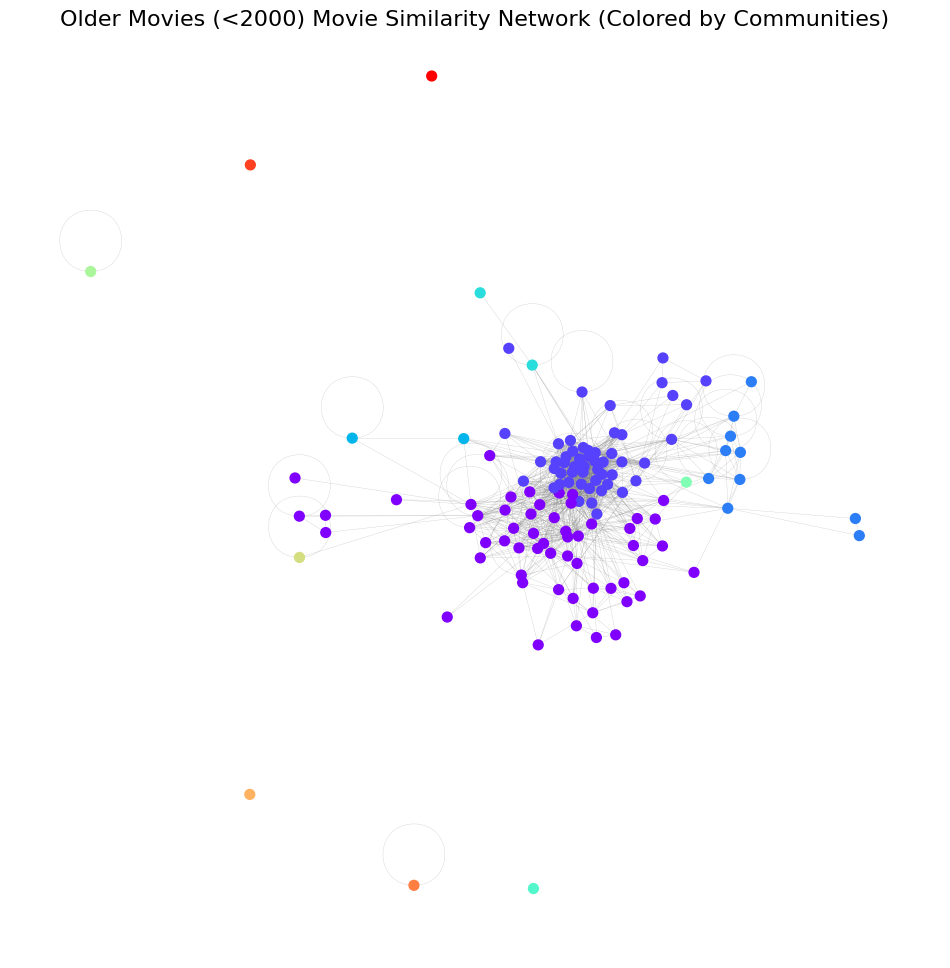

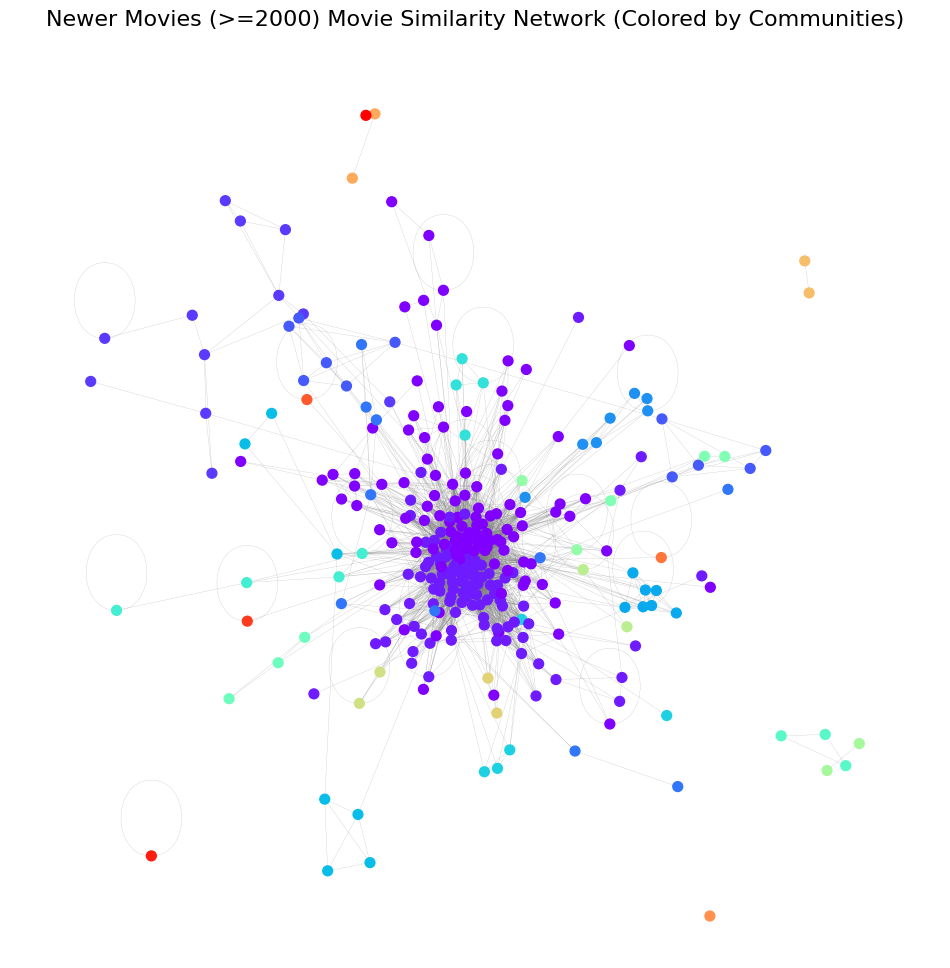

In [74]:
import pandas as pd
import re
import string
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx

# ---------------------------
# 1. Load Data
# ---------------------------
final_aggregated_df = pd.read_csv('final_merged_dataset_cleaned.csv')

# Clean the reviews
final_aggregated_df['cleaned_review'] = final_aggregated_df['review_content'].fillna('').replace('nan', '')
final_aggregated_df['year'] = final_aggregated_df['title'].str.extract(r'\((\d{4})\)').astype(float)

# Split older and newer movies
older_df = final_aggregated_df[final_aggregated_df['year'] < 2000].copy()
newer_df = final_aggregated_df[final_aggregated_df['year'] >= 2000].copy()

# ---------------------------
# 2. TF-IDF Vectorization and Clustering
# ---------------------------
def build_clusters(df, num_clusters=5):
    tfidf_vectorizer = TfidfVectorizer(
        stop_words='english',
        max_features=1000,
        ngram_range=(1, 2)
    )
    tfidf_matrix = tfidf_vectorizer.fit_transform(df['cleaned_review'])
    feature_names = tfidf_vectorizer.get_feature_names_out()

    kmeans = KMeans(n_clusters=num_clusters, random_state=42)
    kmeans.fit(tfidf_matrix)

    df['cluster'] = kmeans.labels_
    return df, tfidf_matrix, tfidf_vectorizer, kmeans

# Build clusters for older and newer movies
older_df, older_tfidf_matrix, older_vec, older_kmeans = build_clusters(older_df, num_clusters=5)
newer_df, newer_tfidf_matrix, newer_vec, newer_kmeans = build_clusters(newer_df, num_clusters=10)

# ---------------------------
# 3. Print Top Terms for Each Cluster
# ---------------------------
def print_top_terms_per_cluster(tfidf_matrix, feature_names, kmeans, num_terms=10):
    order_centroids = kmeans.cluster_centers_.argsort()[:, ::-1]
    for cluster_id in range(kmeans.n_clusters):
        top_terms = [feature_names[ind] for ind in order_centroids[cluster_id, :num_terms]]
        print(f"Cluster {cluster_id}: {', '.join(top_terms)}")

print("\nTop Terms for Older Movie Communities:")
print_top_terms_per_cluster(older_tfidf_matrix, older_vec.get_feature_names_out(), older_kmeans)

print("\nTop Terms for Newer Movie Communities:")
print_top_terms_per_cluster(newer_tfidf_matrix, newer_vec.get_feature_names_out(), newer_kmeans)

# ---------------------------
# 4. Build Similarity Networks
# ---------------------------
def build_similarity_network(tfidf_matrix, titles, threshold=0.3):
    """
    Build a similarity network based on cosine similarity threshold.
    :param tfidf_matrix: TF-IDF matrix for movie reviews
    :param titles: Series of movie titles (reset index before passing)
    :param threshold: Minimum similarity to consider an edge
    :return: NetworkX Graph object
    """
    similarity_matrix = (tfidf_matrix * tfidf_matrix.T).toarray()
    G = nx.Graph()

    # Reset the index to align with the similarity matrix
    titles = titles.reset_index(drop=True)

    for i, title in enumerate(titles):
        G.add_node(title)
        for j in range(i + 1, len(titles)):
            if similarity_matrix[i, j] > threshold:
                G.add_edge(title, titles[j], weight=similarity_matrix[i, j])
    return G

# Build networks for older and newer movies
G_older = build_similarity_network(older_tfidf_matrix, older_df['title'])
G_newer = build_similarity_network(newer_tfidf_matrix, newer_df['title'])


# ---------------------------
# 5. Visualize Networks with Communities
# ---------------------------
def visualize_network_with_communities(G, era_name):
    plt.figure(figsize=(12, 12))
    pos = nx.spring_layout(G, k=0.15, iterations=50)

    communities = nx.algorithms.community.greedy_modularity_communities(G)
    community_colors = plt.cm.rainbow(np.linspace(0, 1, len(communities)))

    node_colors = {}
    for idx, community in enumerate(communities):
        for node in community:
            node_colors[node] = community_colors[idx]

    nx.draw_networkx_nodes(G, pos, node_size=50, node_color=[node_colors[n] for n in G.nodes()])
    nx.draw_networkx_edges(G, pos, alpha=0.5, edge_color='gray', width=0.2)
    plt.title(f"{era_name} Movie Similarity Network (Colored by Communities)", fontsize=16)
    plt.axis('off')
    plt.show()

visualize_network_with_communities(G_older, "Older Movies (<2000)")
visualize_network_with_communities(G_newer, "Newer Movies (>=2000)")

In the older movies graph, the network is smaller and denser, with tightly connected clusters that reflect focused themes such as Disney animations and classic action films. The compact structure highlights the relatively narrow range of genres prevalent in earlier decades.

In contrast, the newer movies graph reveals a larger and more diverse network with broader connections. Communities in this graph are more numerous and varied, representing themes such as Pixar animations, superhero franchises, and modern horror. The sprawling structure of the newer movies network reflects the expansion of genres and richer storytelling in recent years.

In [76]:
import plotly.graph_objects as go
import pandas as pd

# ---------------------------
# 1. Degree Distribution (Interactive with Plotly)
# ---------------------------
def plot_interactive_degree_distribution(G, era_name):
    # Compute degree distribution
    degrees = [deg for _, deg in G.degree()]
    degree_counts = pd.Series(degrees).value_counts().reset_index()
    degree_counts.columns = ['Degree', 'Frequency']
    degree_counts = degree_counts.sort_values('Degree')
    
    # Print degree distribution
    print(f"\nDegree Distribution for {era_name} Network:")
    print(degree_counts)
    
    # Interactive bar chart with Plotly
    fig = go.Figure(data=[
        go.Bar(
            x=degree_counts['Degree'],
            y=degree_counts['Frequency'],
            text=degree_counts['Frequency'],
            textposition='outside'
        )
    ])
    fig.update_layout(
        title=f"Interactive Degree Distribution for {era_name} Network",
        xaxis_title="Degree",
        yaxis_title="Frequency",
        template="plotly_white"
    )
    fig.show()

# Example for older and newer movies
plot_interactive_degree_distribution(G_older, "Older (<2000)")
plot_interactive_degree_distribution(G_newer, "Newer (>=2000)")



Degree Distribution for Older (<2000) Network:
    Degree  Frequency
10       0          4
19       1          3
4        2          7
11       3          4
1        4          9
33       5          1
27       6          2
17       7          3
14       8          3
3        9          7
0       10          9
2       11          7
34      12          1
41      13          1
8       15          4
15      16          3
43      17          1
23      19          2
38      20          1
12      21          3
20      22          2
21      23          2
16      24          3
31      27          1
32      28          1
36      31          1
40      32          1
13      33          3
39      34          1
22      35          2
26      37          2
28      38          2
25      39          2
44      40          1
45      41          1
7       42          4
18      44          3
5       45          5
6       46          5
42      47          1
9       50          4
24      53          2
30    


Degree Distribution for Newer (>=2000) Network:
    Degree  Frequency
43       0          2
3        1         15
1        2         20
0        3         22
2        4         18
..     ...        ...
87     123          1
46     124          2
88     127          1
81     132          1
83     140          1

[93 rows x 2 columns]


The degree distribution graphs provide insights into the connectivity patterns within the movie similarity networks for older and newer movies.

In the older movie network (<2000), the degree distribution is more balanced, with a noticeable peak around nodes having degrees between 10 to 15. This reflects a dense network where movies are moderately connected, indicating smaller, well-defined communities of similar films.

In contrast, the newer movie network (>=2000) shows a broader range of degrees, with many nodes having low connectivity (degree 1–3) and a few highly connected nodes with degrees exceeding 100. This indicates a more diverse and expansive network, with highly popular movies acting as hubs connecting various subgroups. This trend aligns with the increasing variety and popularity of certain modern film genres and franchises, demonstrating how newer movies contribute to a more interconnected network.

## **Network Analysis Reflection**

##### *Older Movie Network (<2000)* :

The similarity network for older movies shows a relatively structured and dense layout. The degree distribution suggests most movies are moderately connected, with degrees ranging between 10 and 15 for the largest clusters. The graph visualization highlights smaller, well-defined communities, each representing groups of movies with closely related reviews and themes. These communities suggest that older films may share stronger thematic or stylistic similarities within smaller clusters, which is reflected in the concentrated connectivity of the network.

##### *Newer Movie Network (>=2000)* :

The network for newer movies is much more expansive, with a broader degree distribution and a significant number of highly connected nodes. This reflects a more interconnected web of films, where certain movies or genres act as hubs, bridging multiple communities. This could be attributed to modern franchises and globalized trends in filmmaking, leading to greater overlaps in thematic and stylistic elements across movies. The presence of low-degree nodes also reflects the growing diversity in movie content, capturing niche genres or less mainstream productions.

## **Key Differences and Insights** 

The older network emphasizes tightly-knit communities, suggesting a narrower focus on shared themes and styles. In contrast, the newer network reveals a more interconnected structure, driven by the influence of highly popular movies and the expansion of diverse genres. This analysis highlights how the evolution of the film industry has impacted movie similarity and connectivity, with modern films showing greater overlap and centralization. These networks not only reflect thematic relationships but also provide a glimpse into the shifting trends in audience preferences and filmmaking styles over time.